# Compare today's matter power spectra for PM, BullFrog 🐸 and COLA

Mayeul Aubin, Tristan Hoellinger<br/>
Institut d'Astrophysique de Paris</br>
tristan.hoellinger@iap.fr

Plot today's matter power spectra for PM, BullFrog 🐸 and COLA, given pre-computed simulations.

In [20]:
from pathlib import Path
import pickle
import os
import numpy as np
import importlib
from pysbmy.fft import read_FourierGrid, FourierGrid
from pysbmy.correlations import get_autocorrelation, get_crosscorrelation

from tools import read_field
import plot_utils
from plot_utils import *

importlib.reload(plot_utils);

## Set up the environment

In [ ]:
root = "/home/aubin/data/BullFrog/comparison_article/"
force_reload = False

run_ids_dict = {
    "lin z24": "N768z24",
    "lin z49": "linN768z49",
    "log z49": "logN768z49",
    "tsb z49":"DkdkN768z49",
}

workdir = {}
simdir = {}
outdir = {}

for key, value in run_ids_dict.items():
    workdir[key] = f"{root}params/{value}/"
    simdir[key] = f"{root}sims/{value}/"

    outdir[key] = simdir[key] + "plots/"

## Load data and plot

In [22]:
N, L, nsteps_pm_list, nsteps_cola_list, nsteps_bullfrog_list = {}, {}, {}, {}, {}

for key in run_ids_dict.keys():
    Path(outdir[key]).mkdir(parents=True, exist_ok=True)

    with open(workdir[key] + "params.pkl", "rb") as f:
        params = pickle.load(f)

    N[key] = params["N"]
    L[key] = params["L"]
    nsteps_pm_list[key] = params["nsteps_pm"]
    nsteps_cola_list[key] = params["nsteps_cola"]
    nsteps_bullfrog_list[key] = params["nsteps_bullfrog"]
    print(
        key,
        N[key],
        L[key],
        nsteps_pm_list[key],
        nsteps_cola_list[key],
        nsteps_bullfrog_list[key],
    )

N = min(N.values())
L = min(L.values())



### Plot the evolved dark matter density fields

In [23]:
# slice_ijk = (N // 2, slice(None), slice(None))
# DELTA_LPT = read_field(simdir + "lpt_density.h5").data[slice_ijk]

# vmin=0
# vmax=3

# all_nsteps = sorted(list(set(nsteps_cola_list + nsteps_bullfrog_list)))[:4]

# ncols = len(all_nsteps) + 1
# nrows = 2
# fig, axs = plt.subplots(nrows, ncols, figsize=(5 * ncols+2, 5 * nrows), sharex=True, sharey=True)
# axs[0, 0].imshow(np.log(2 + DELTA_LPT), cmap=cmap, rasterized=True, vmin=vmin, vmax=vmax)
# axs[0, 0].set_title("LPT", fontsize=fs_titles)
# DELTA_PM = read_field(simdir + f"nsteps{max(nsteps_pm_list)}_final_density_pm.h5").data[slice_ijk]
# axs[1, 0].imshow(np.log(2 + DELTA_PM), cmap=cmap, rasterized=True, vmin=vmin, vmax=vmax)
# axs[1, 0].set_title(f"PM with $n_\\mathrm{{steps}}={max(nsteps_pm_list)}$", fontsize=fs_titles)
# for i, nsteps in enumerate(all_nsteps):
#     if nsteps in nsteps_cola_list:
#         DELTA_COLA = read_field(simdir + f"nsteps{nsteps}_final_density_cola.h5").data[slice_ijk]
#         axs[0, i + 1].imshow(np.log(2 + DELTA_COLA), cmap=cmap, rasterized=True, vmin=vmin, vmax=vmax)
#         axs[0, i + 1].set_title(f"COLA with $n_\\mathrm{{steps}}={nsteps}$", fontsize=fs_titles)
#     if nsteps in nsteps_bullfrog_list:
#         DELTA_BULLFROG = read_field(simdir + f"nsteps{nsteps}_final_density_bullfrog.h5").data[
#             slice_ijk
#         ]
#         im = axs[1, i + 1].imshow(np.log(2 + DELTA_BULLFROG), cmap=cmap, rasterized=True, vmin=vmin, vmax=vmax)
#         axs[1, i + 1].set_title(
#             f"BullFrog with $n_\\mathrm{{steps}}={nsteps}$", fontsize=fs_titles
#         )
# for ax in axs.flatten():
#     ax.spines[["top", "right", "bottom", "left"]].set_visible(False)
# for ax in axs[:, 0]:
#     ax.set_yticks([0, N // 2, N])
#     ax.set_yticklabels([f"{-L/2:.0f}", "0", f"{L/2:.0f}"], fontsize=fs)
# for ax in axs[1, :]:
#     ax.set_xticks([0, N // 2, N])
#     ax.set_xticklabels([f"{-L/2:.0f}", "0", f"{L/2:.0f}"], fontsize=fs)
# for i in range(nrows):
#     for j in range(ncols):
#         if axs[i, j].get_title() == "":
#             axs[i, j].axis("off")

# plt.tight_layout()
# fig.colorbar(im,ax=axs)

# # fig.savefig(outdir + "density_fields.png", bbox_inches="tight", transparent=True, dpi=300)
# # fig.savefig(outdir + "density_fields.pdf", bbox_inches="tight", transparent=True)
# plt.show()

### Compute and plot the power spectra of the evolved dark matter fields

In [24]:
Pinit = 100
trim_threshold = 1  # Min number of modes required per bin for the summaries
# logkmin = np.log10(4 * np.pi / (np.sqrt(3) * L))
logkmin = np.log10(3e-3)
kmax = np.pi * N / L
Pbins_left_bnds = np.logspace(logkmin, np.log10(kmax), Pinit + 1, dtype=np.float32)
Pbins_left_bnds = Pbins_left_bnds[:-1]

G = FourierGrid(
    L,
    L,
    L,
    N,
    N,
    N,
    k_modes=Pbins_left_bnds,
    kmax=kmax,
    trim_bins=True,
    trim_threshold=trim_threshold,
)

In [25]:
# G = read_FourierGrid(simdir + "input_ss_k_grid.h5")
k = G.k_modes
AliasingCorr = False

key="log z49"
nsteps = max(nsteps_pm_list[key])
DELTA_REF = read_field(simdir[key] + f"nsteps{nsteps}_final_density_pm.h5")

if not os.path.exists(f"{root}power_spectra.pkl") or force_reload:

    Pk_PM, Pk_COLA, Pk_BULLFROG, Pk_INI, Pk_LPT = {}, {}, {}, {}, {}
    Sk_PM, Sk_COLA, Sk_BULLFROG, Sk_INI, Sk_LPT = {}, {}, {}, {}, {}
    Rk_PM, Rk_COLA, Rk_BULLFROG = {}, {}, {} 

    for key in run_ids_dict.keys():

        DELTA = read_field(simdir[key] + "initial_density.h5")
        _Pk_INI, _Vk_INI = get_autocorrelation(DELTA, G, AliasingCorr)
        _Pk_INI, _Vk_INI = _Pk_INI[1:], _Vk_INI[1:]
        _Sk_INI = np.sqrt(_Vk_INI)

        Pk_INI[key] = _Pk_INI
        Sk_INI[key] = _Sk_INI

        DELTA = read_field(simdir[key] + "lpt_density.h5")
        _Pk_LPT, _Vk_LPT = get_autocorrelation(DELTA, G, AliasingCorr)
        _Pk_LPT, _Vk_LPT = _Pk_LPT[1:], _Vk_LPT[1:]
        _Sk_LPT = np.sqrt(_Vk_LPT)

        Pk_LPT[key] = _Pk_LPT
        Sk_LPT[key] = _Sk_LPT

        Pk_PM_list = []
        Sk_PM_list = []
        Rk_PM_list = []
        for nsteps in nsteps_pm_list[key]:
            DELTA = read_field(simdir[key] + f"nsteps{nsteps}_final_density_pm.h5")
            _Pk_PM, _Vk_PM = get_autocorrelation(DELTA, G, AliasingCorr)
            _Pk_PM, _Vk_PM = _Pk_PM[1:], _Vk_PM[1:]
            _Sk_PM = np.sqrt(_Vk_PM)
            Pk_PM_list.append(_Pk_PM)
            Sk_PM_list.append(_Sk_PM)
            _,_,_Rk_PM,_ = get_crosscorrelation(DELTA_REF, DELTA, G, AliasingCorr)
            _Rk_PM=_Rk_PM[1:]
            Rk_PM_list.append(_Rk_PM)

        Pk_ref = Pk_PM_list[-1]

        Pk_PM[key] = np.array(Pk_PM_list)
        Sk_PM[key] = np.array(Sk_PM_list)
        Rk_PM[key] = np.array(Rk_PM_list)

        Pk_COLA_list = []
        Sk_COLA_list = []
        Rk_COLA_list = []
        for nsteps in nsteps_cola_list[key]:
            DELTA = read_field(simdir[key] + f"nsteps{nsteps}_final_density_cola.h5")
            _Pk_COLA, _Vk_COLA = get_autocorrelation(DELTA, G, AliasingCorr)
            _Pk_COLA, _Vk_COLA = _Pk_COLA[1:], _Vk_COLA[1:]
            _Sk_COLA = np.sqrt(_Vk_COLA)
            Pk_COLA_list.append(_Pk_COLA)
            Sk_COLA_list.append(_Sk_COLA)
            _,_,_Rk_COLA,_ = get_crosscorrelation(DELTA_REF, DELTA, G, AliasingCorr)
            _Rk_COLA=_Rk_COLA[1:]
            Rk_COLA_list.append(_Rk_COLA)

        Pk_COLA[key] = np.array(Pk_COLA_list)
        Sk_COLA[key] = np.array(Sk_COLA_list)
        Rk_COLA[key] = np.array(Rk_COLA_list)

        Pk_BULLFROG_list = []
        Sk_BULLFROG_list = []
        Rk_BULLFROG_list = []
        for nsteps in nsteps_bullfrog_list[key]:
            DELTA = read_field(
                simdir[key] + f"nsteps{nsteps}_final_density_bullfrog.h5"
            )
            _Pk_BULLFROG, _Vk_BULLFROG = get_autocorrelation(DELTA, G, AliasingCorr)
            _Pk_BULLFROG, _Vk_BULLFROG = _Pk_BULLFROG[1:], _Vk_BULLFROG[1:]
            _Sk_BULLFROG = np.sqrt(_Vk_BULLFROG)
            Pk_BULLFROG_list.append(_Pk_BULLFROG)
            Sk_BULLFROG_list.append(_Sk_BULLFROG)
            _,_,_Rk_BULLFROG,_ = get_crosscorrelation(DELTA_REF, DELTA, G, AliasingCorr)
            _Rk_BULLFROG=_Rk_BULLFROG[1:]
            Rk_BULLFROG_list.append(_Rk_BULLFROG)

        Pk_BULLFROG[key] = np.array(Pk_BULLFROG_list)
        Sk_BULLFROG[key] = np.array(Sk_BULLFROG_list)
        Rk_BULLFROG[key] = np.array(Rk_BULLFROG_list)

    with open(f"{root}/power_spectra.pkl", "wb") as f:
        pickle.dump(
            {
                "Pk_PM": Pk_PM,
                "Pk_COLA": Pk_COLA,
                "Pk_BULLFROG": Pk_BULLFROG,
                "Pk_INI": Pk_INI,
                "Pk_LPT": Pk_LPT,
                "Sk_PM": Sk_PM,
                "Sk_COLA": Sk_COLA,
                "Sk_BULLFROG": Sk_BULLFROG,
                "Sk_INI": Sk_INI,
                "Sk_LPT": Sk_LPT,
                "Rk_PM": Rk_PM,
                "Rk_COLA": Rk_COLA,
                "Rk_BULLFROG": Rk_BULLFROG,
            },
            f,
        )

else:
    with open(f"{root}/power_spectra.pkl", "rb") as f:
        data = pickle.load(f)
        Pk_PM = data["Pk_PM"]
        Pk_COLA = data["Pk_COLA"]
        Pk_BULLFROG = data["Pk_BULLFROG"]
        Pk_INI = data["Pk_INI"]
        Pk_LPT = data["Pk_LPT"]
        Sk_PM = data["Sk_PM"]
        Sk_COLA = data["Sk_COLA"]
        Sk_BULLFROG = data["Sk_BULLFROG"]
        Sk_INI = data["Sk_INI"]
        Sk_LPT = data["Sk_LPT"]
        Rk_PM = data["Rk_PM"]
        Rk_COLA = data["Rk_COLA"]
        Rk_BULLFROG = data["Rk_BULLFROG"]

In [26]:
Pk = {
    "PM": Pk_PM,
    "COLA": Pk_COLA,
    "BullFrog": Pk_BULLFROG,
    "INI": Pk_INI,
    "LPT": Pk_LPT,
}
Rk = {
    "PM": Rk_PM,
    "COLA": Rk_COLA,
    "BullFrog": Rk_BULLFROG,
}
nsteps_all = {
    "PM": nsteps_pm_list,
    "COLA": nsteps_cola_list,
    "BullFrog": nsteps_bullfrog_list,
}

line_styles = {"PM": "--", "COLA": ":", "BullFrog": "-", "INI": "-", "LPT": "-."}
markers = {"lin z24": "o", "lin z49": "s", "log z49": "^", "tsb z49": "*"}

In [27]:
xlims = [3e-3, 1.1e-1]
ylims = [0.98, 1.02]
bnd1 = 0.002
bnd2 = 0.01
yticks = [0.98, 0.985, 0.99, 0.995, 1, 1.005, 1.01, 1.015, 1.02]

ylims_cc=[0.98, 1.002]
yticks_cc = [0.98, 0.985, 0.99, 0.995, 1,]

Pk_ref = Pk_PM["log z49"][-1]
k = G.k_modes[1:]

## Compare the different time steppings

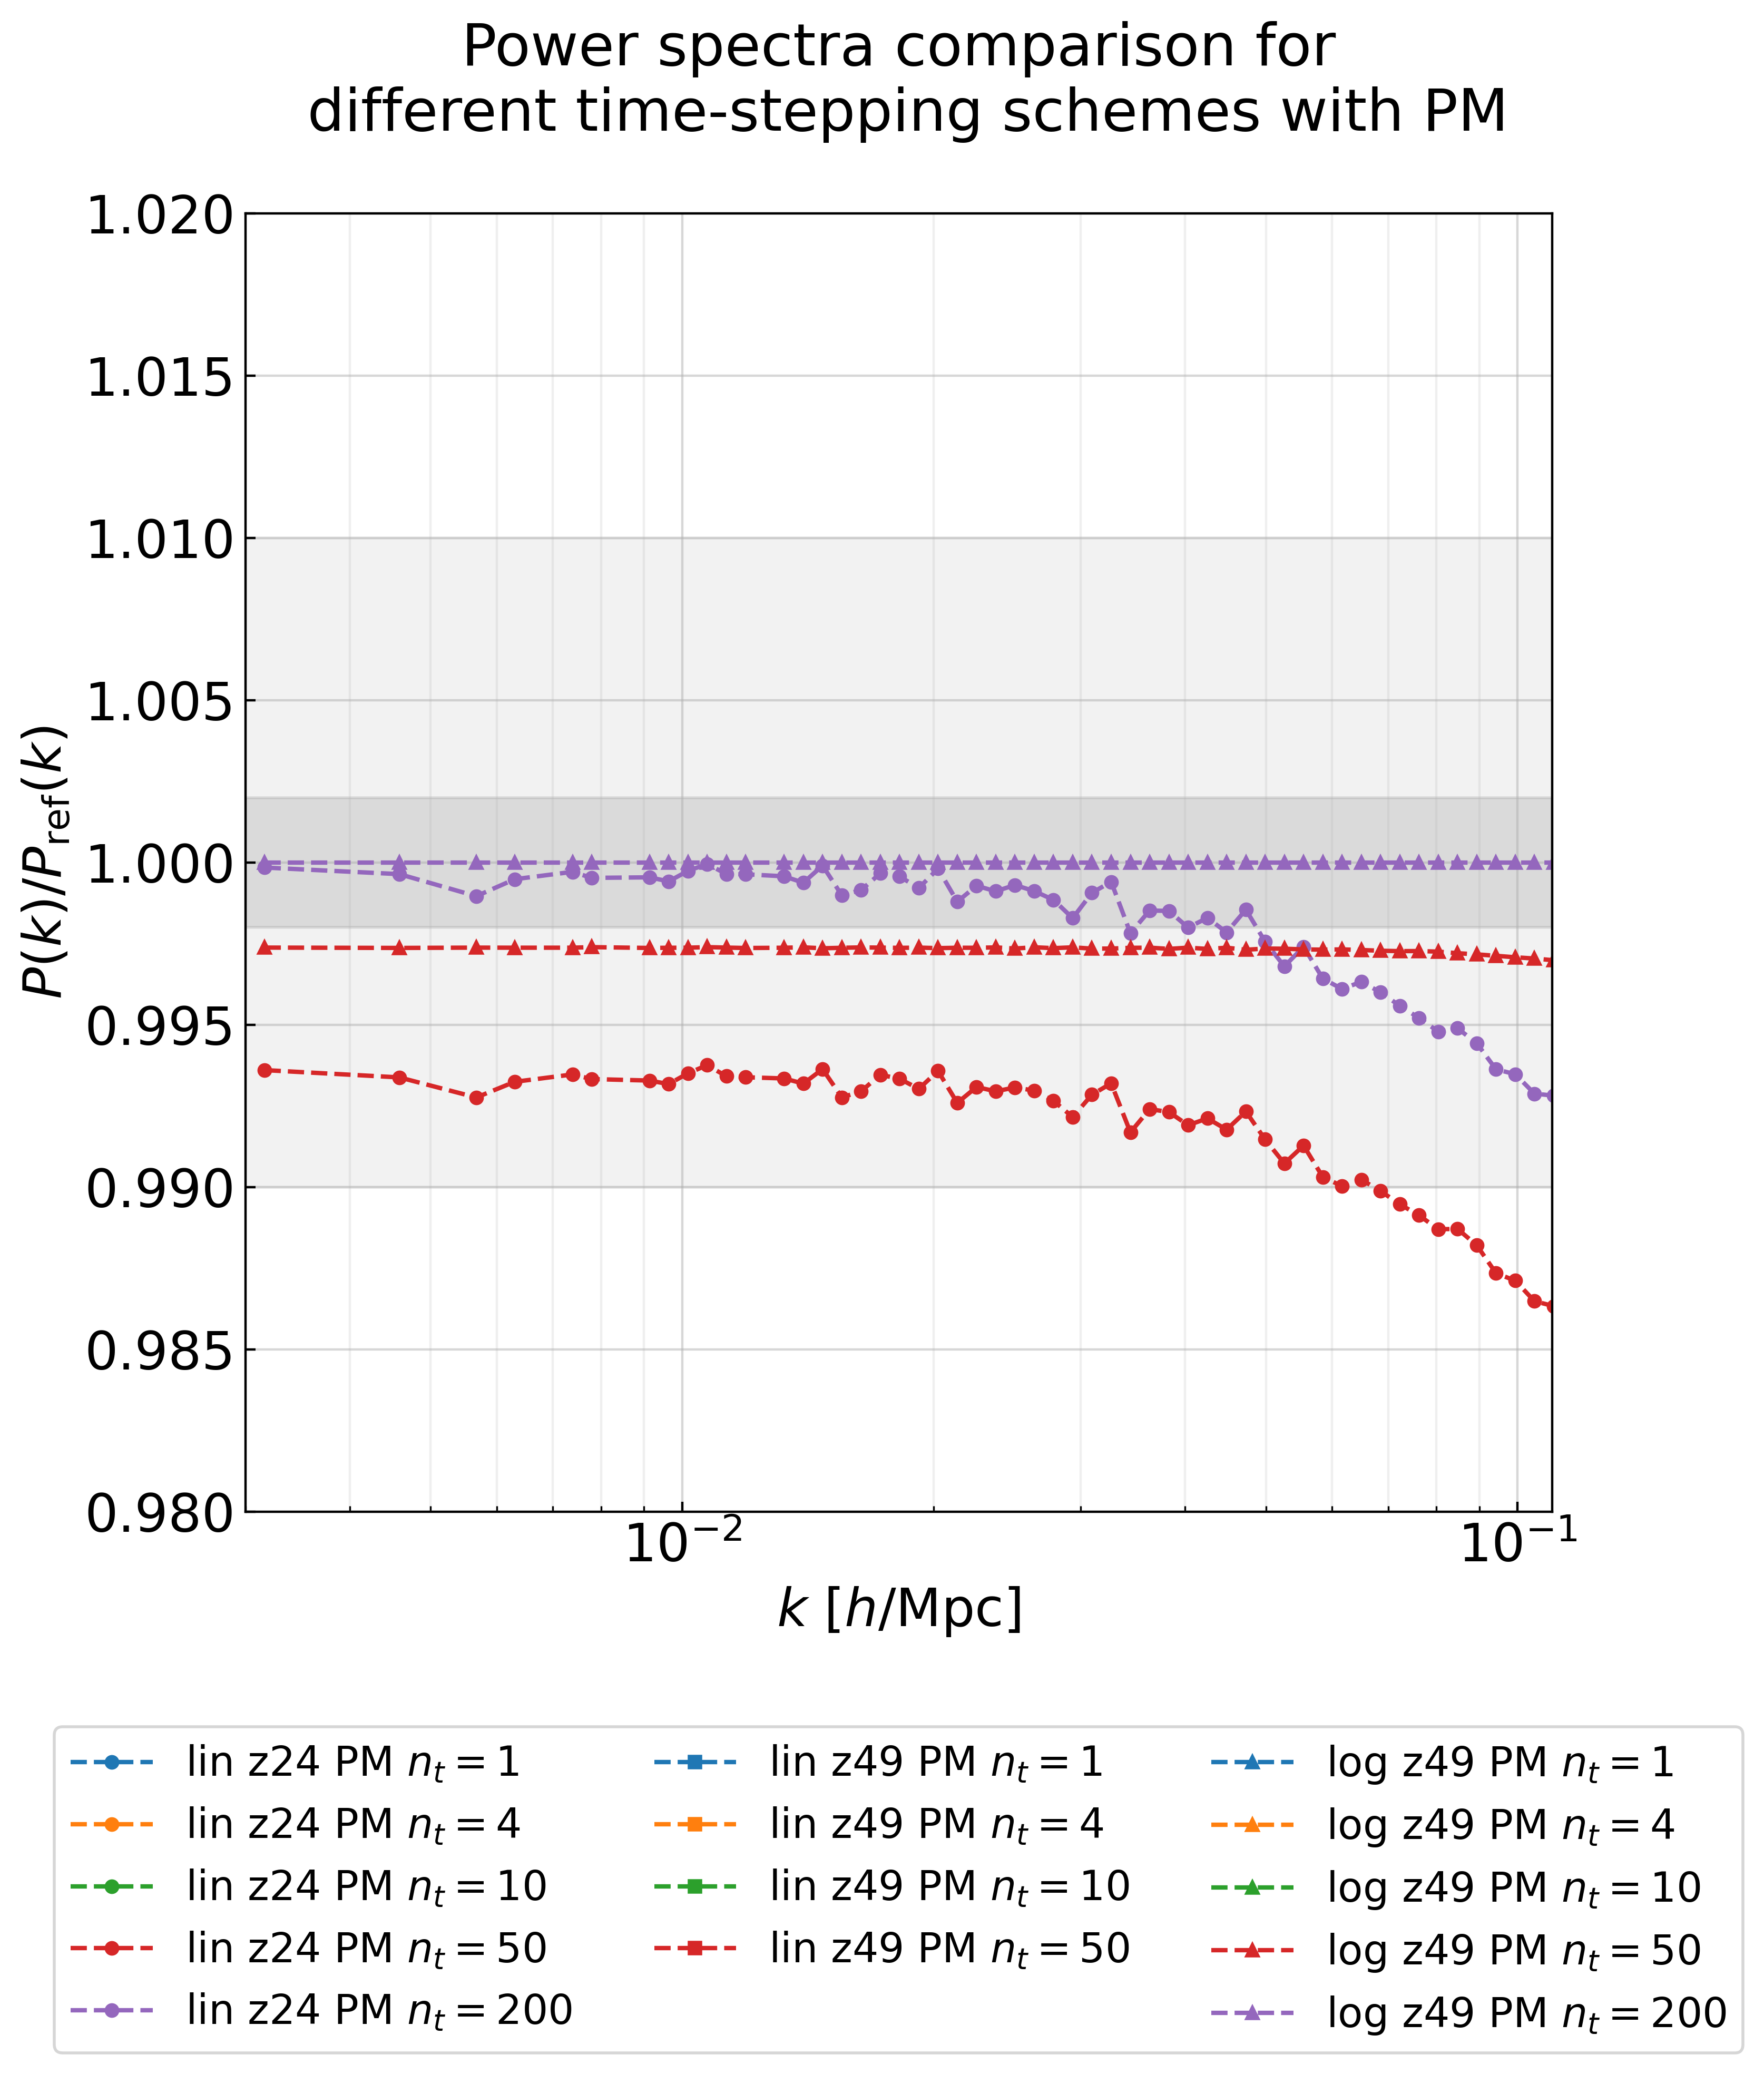

In [28]:
ts_keys = ["lin z24","lin z49", "log z49"]
modes = {"lin z24": ["PM"],"lin z49": ["PM"], "log z49": ["PM"]}

fig, ax = plt.subplots(figsize=(8, 8), dpi=400)

plot_utils.plot_mode_runs_full_comparison(
    ax,
    Pk,
    Pk_ref,
    k,
    ts_keys,
    modes,
    nsteps_all,
    line_styles,
    markers,
    "Power spectra comparison for\n different time-stepping schemes with PM\n",
    xlims,
    ylims,
    yticks,
    bnd1,
    bnd2,
)

fig.show()

## Comparing initial redshifts

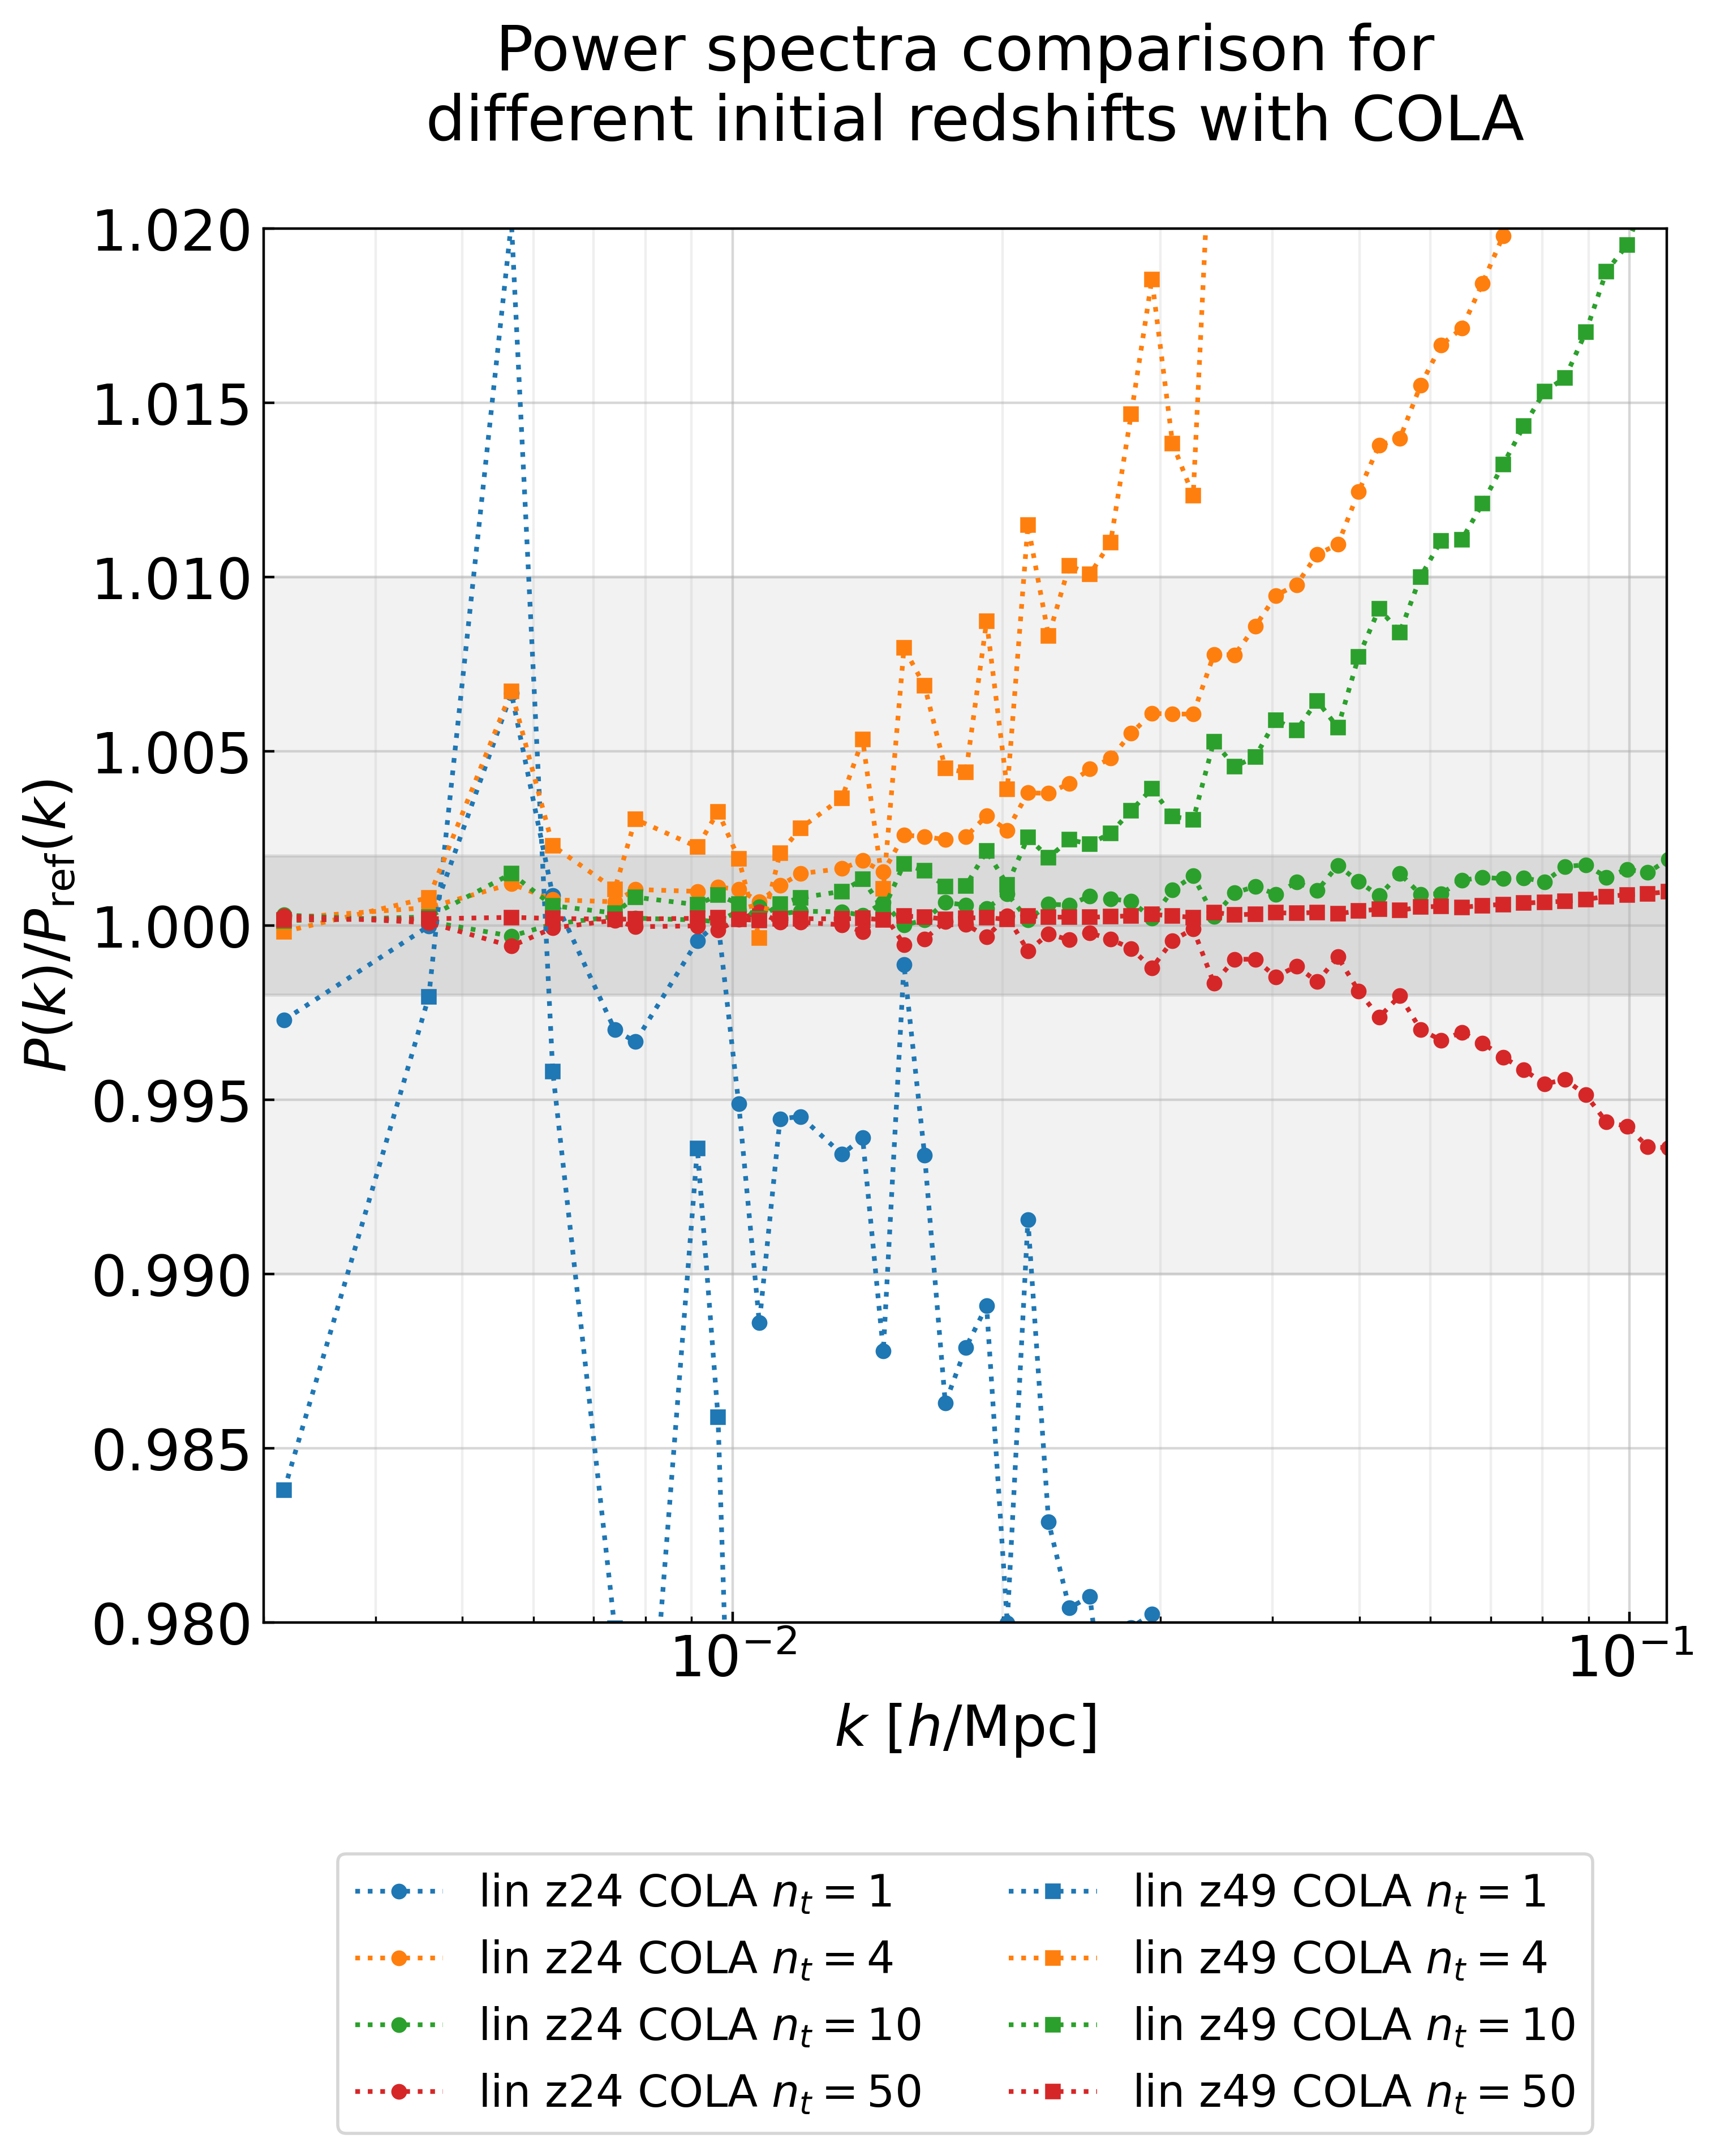

In [29]:
ts_keys = ["lin z24", "lin z49"]
modes = {"lin z24": ["PM", "COLA"], "lin z49": ["PM", "COLA"]}
modes = {"lin z24": ["COLA"], "lin z49": ["COLA"]}

importlib.reload(plot_utils)

fig, ax = plt.subplots(figsize=(8, 8), dpi=400)

plot_utils.plot_mode_runs_full_comparison(
    ax,
    Pk,
    Pk_ref,
    k,
    ts_keys,
    modes,
    nsteps_all,
    line_styles,
    markers,
    "Power spectra comparison for\n different initial redshifts with COLA\n",
    xlims,
    ylims,
    yticks,
    bnd1,
    bnd2,
    False,
    0,
)

fig.show()

## Comparing time stepping distributions for BullFrog

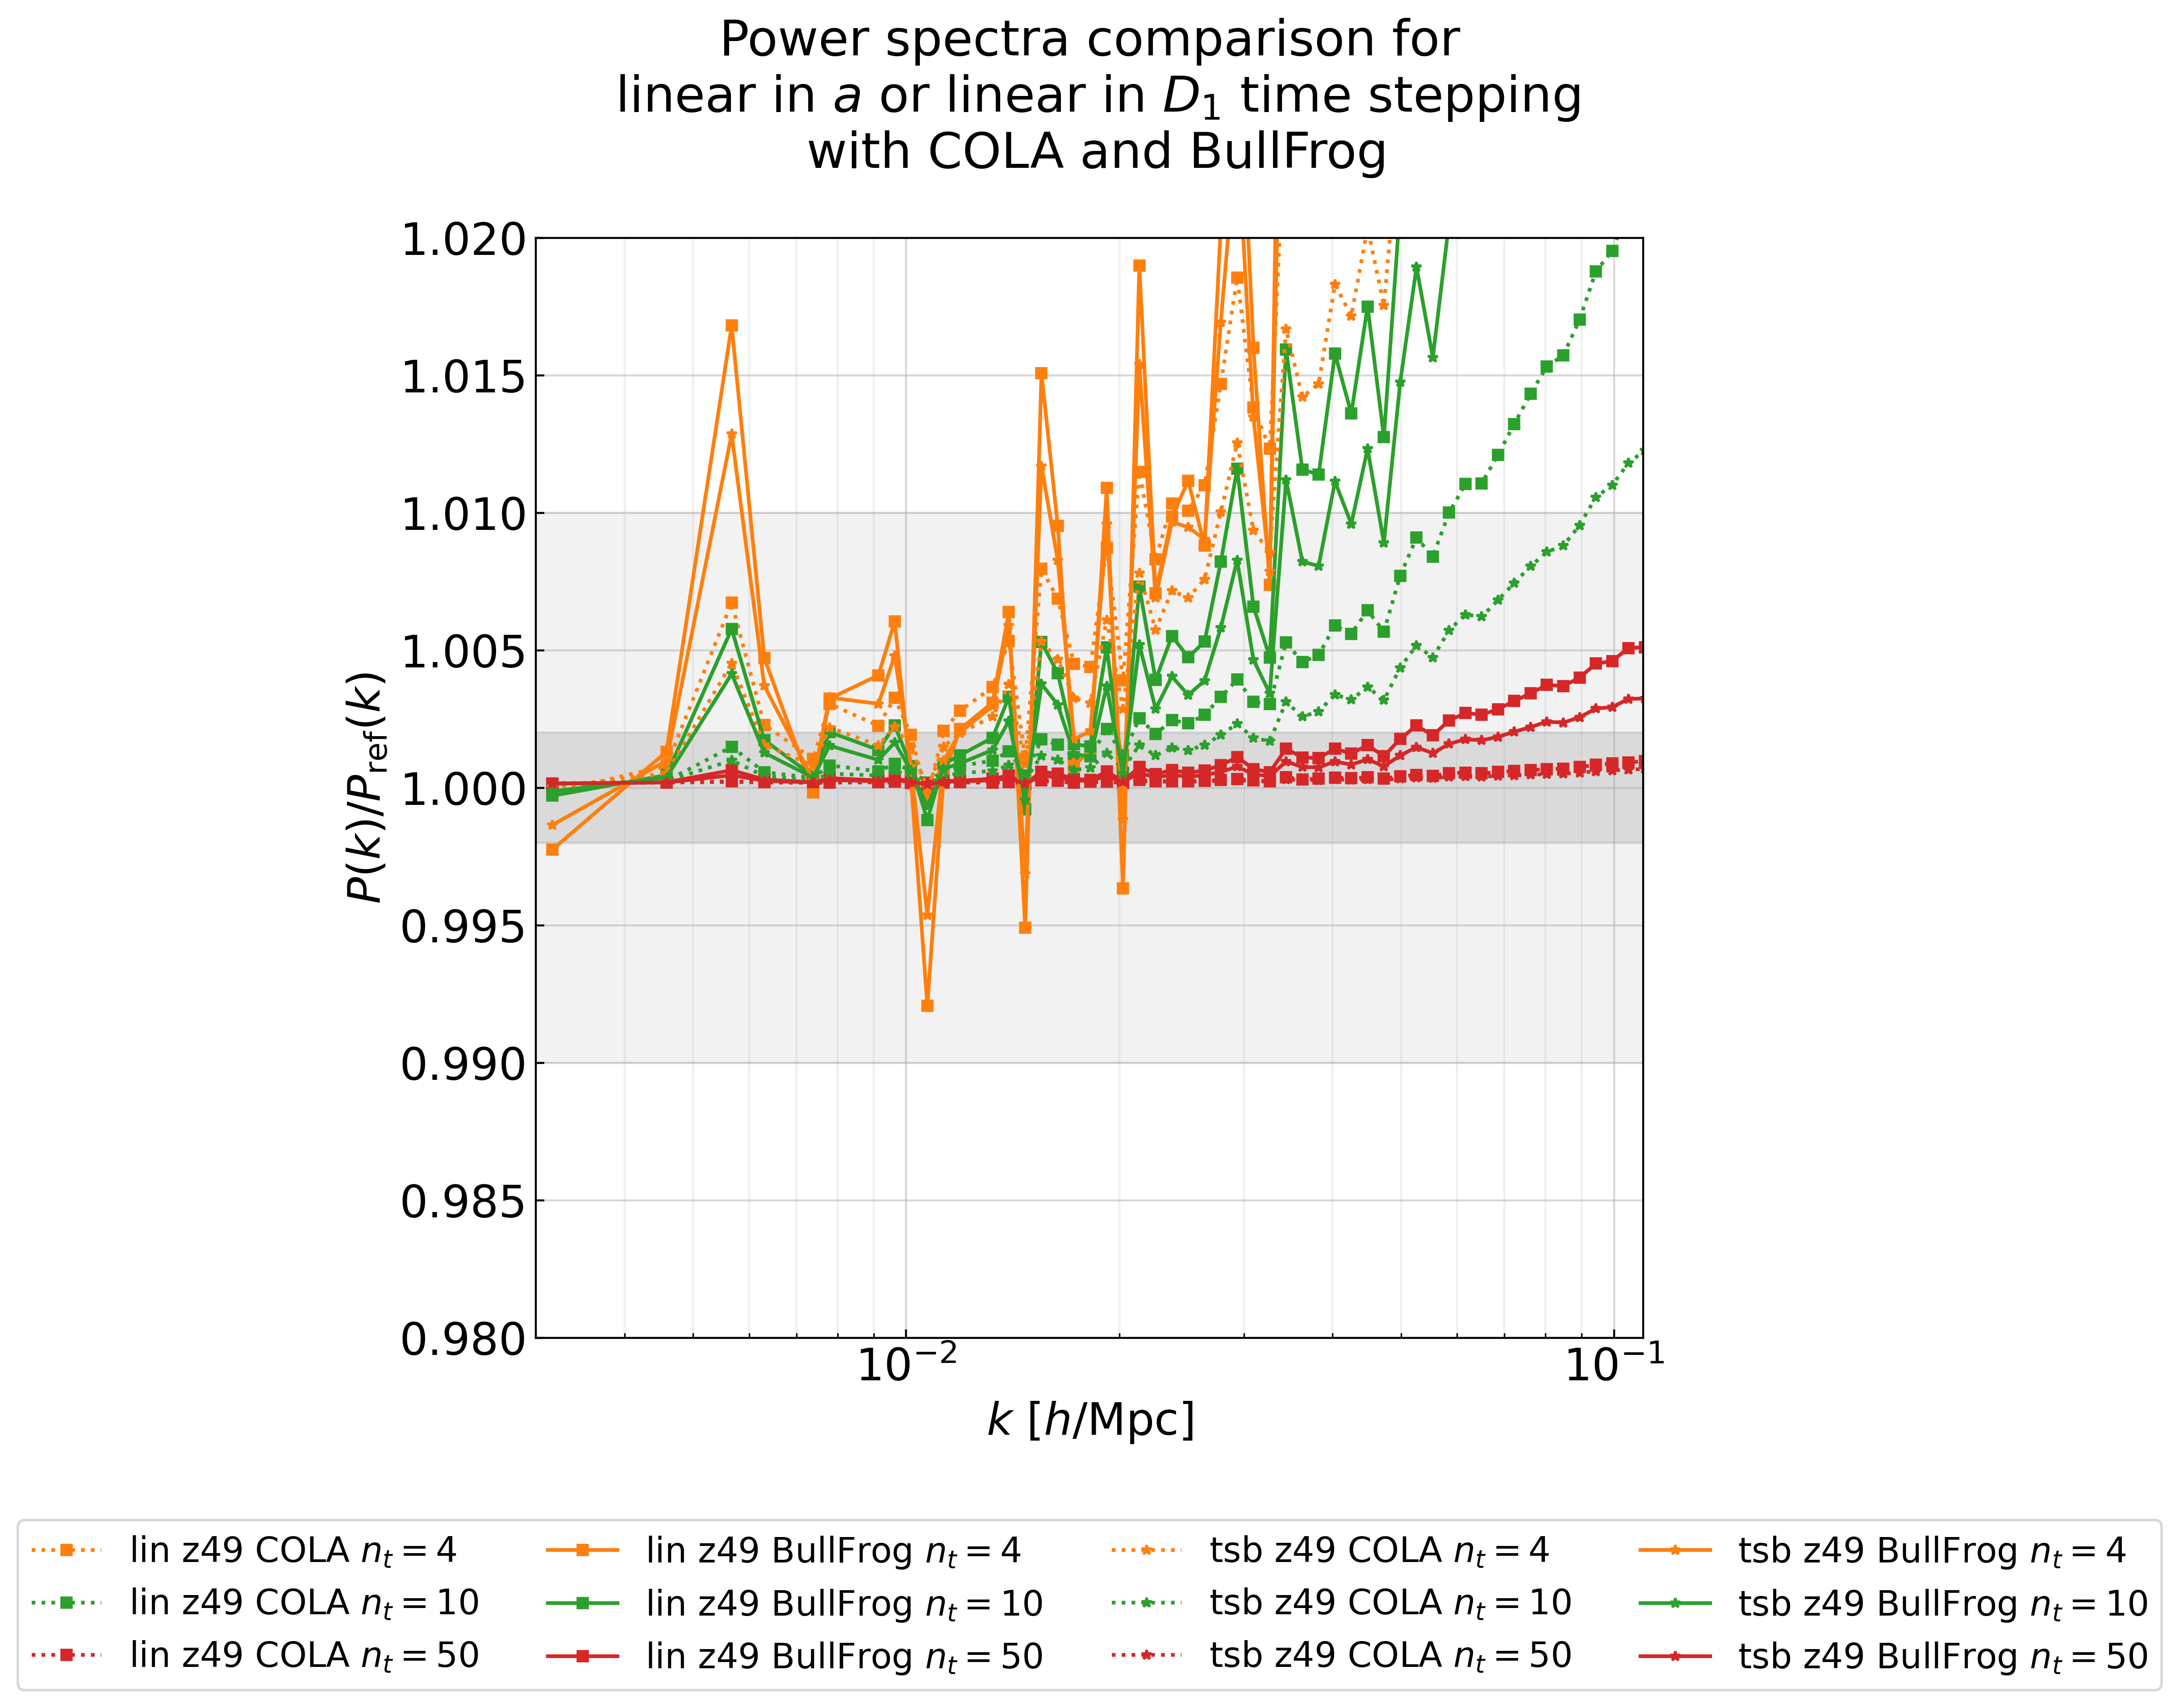

In [30]:
ts_keys = ["lin z49", "tsb z49"]
modes = {"tsb z49": ["COLA","BullFrog"], "lin z49": ["COLA","BullFrog"]}

importlib.reload(plot_utils)

fig, ax = plt.subplots(figsize=(8, 8), dpi=400)

plot_utils.plot_mode_runs_full_comparison(
    ax,
    Pk,
    Pk_ref,
    k,
    ts_keys,
    modes,
    nsteps_all,
    line_styles,
    markers,
    "Power spectra comparison for\n linear in $a$ or linear in $D_1$ time stepping\n with COLA and BullFrog\n",
    xlims,
    ylims,
    yticks,
    bnd1,
    bnd2,
    False,
    2,
)

fig.show()

## Overall comparison

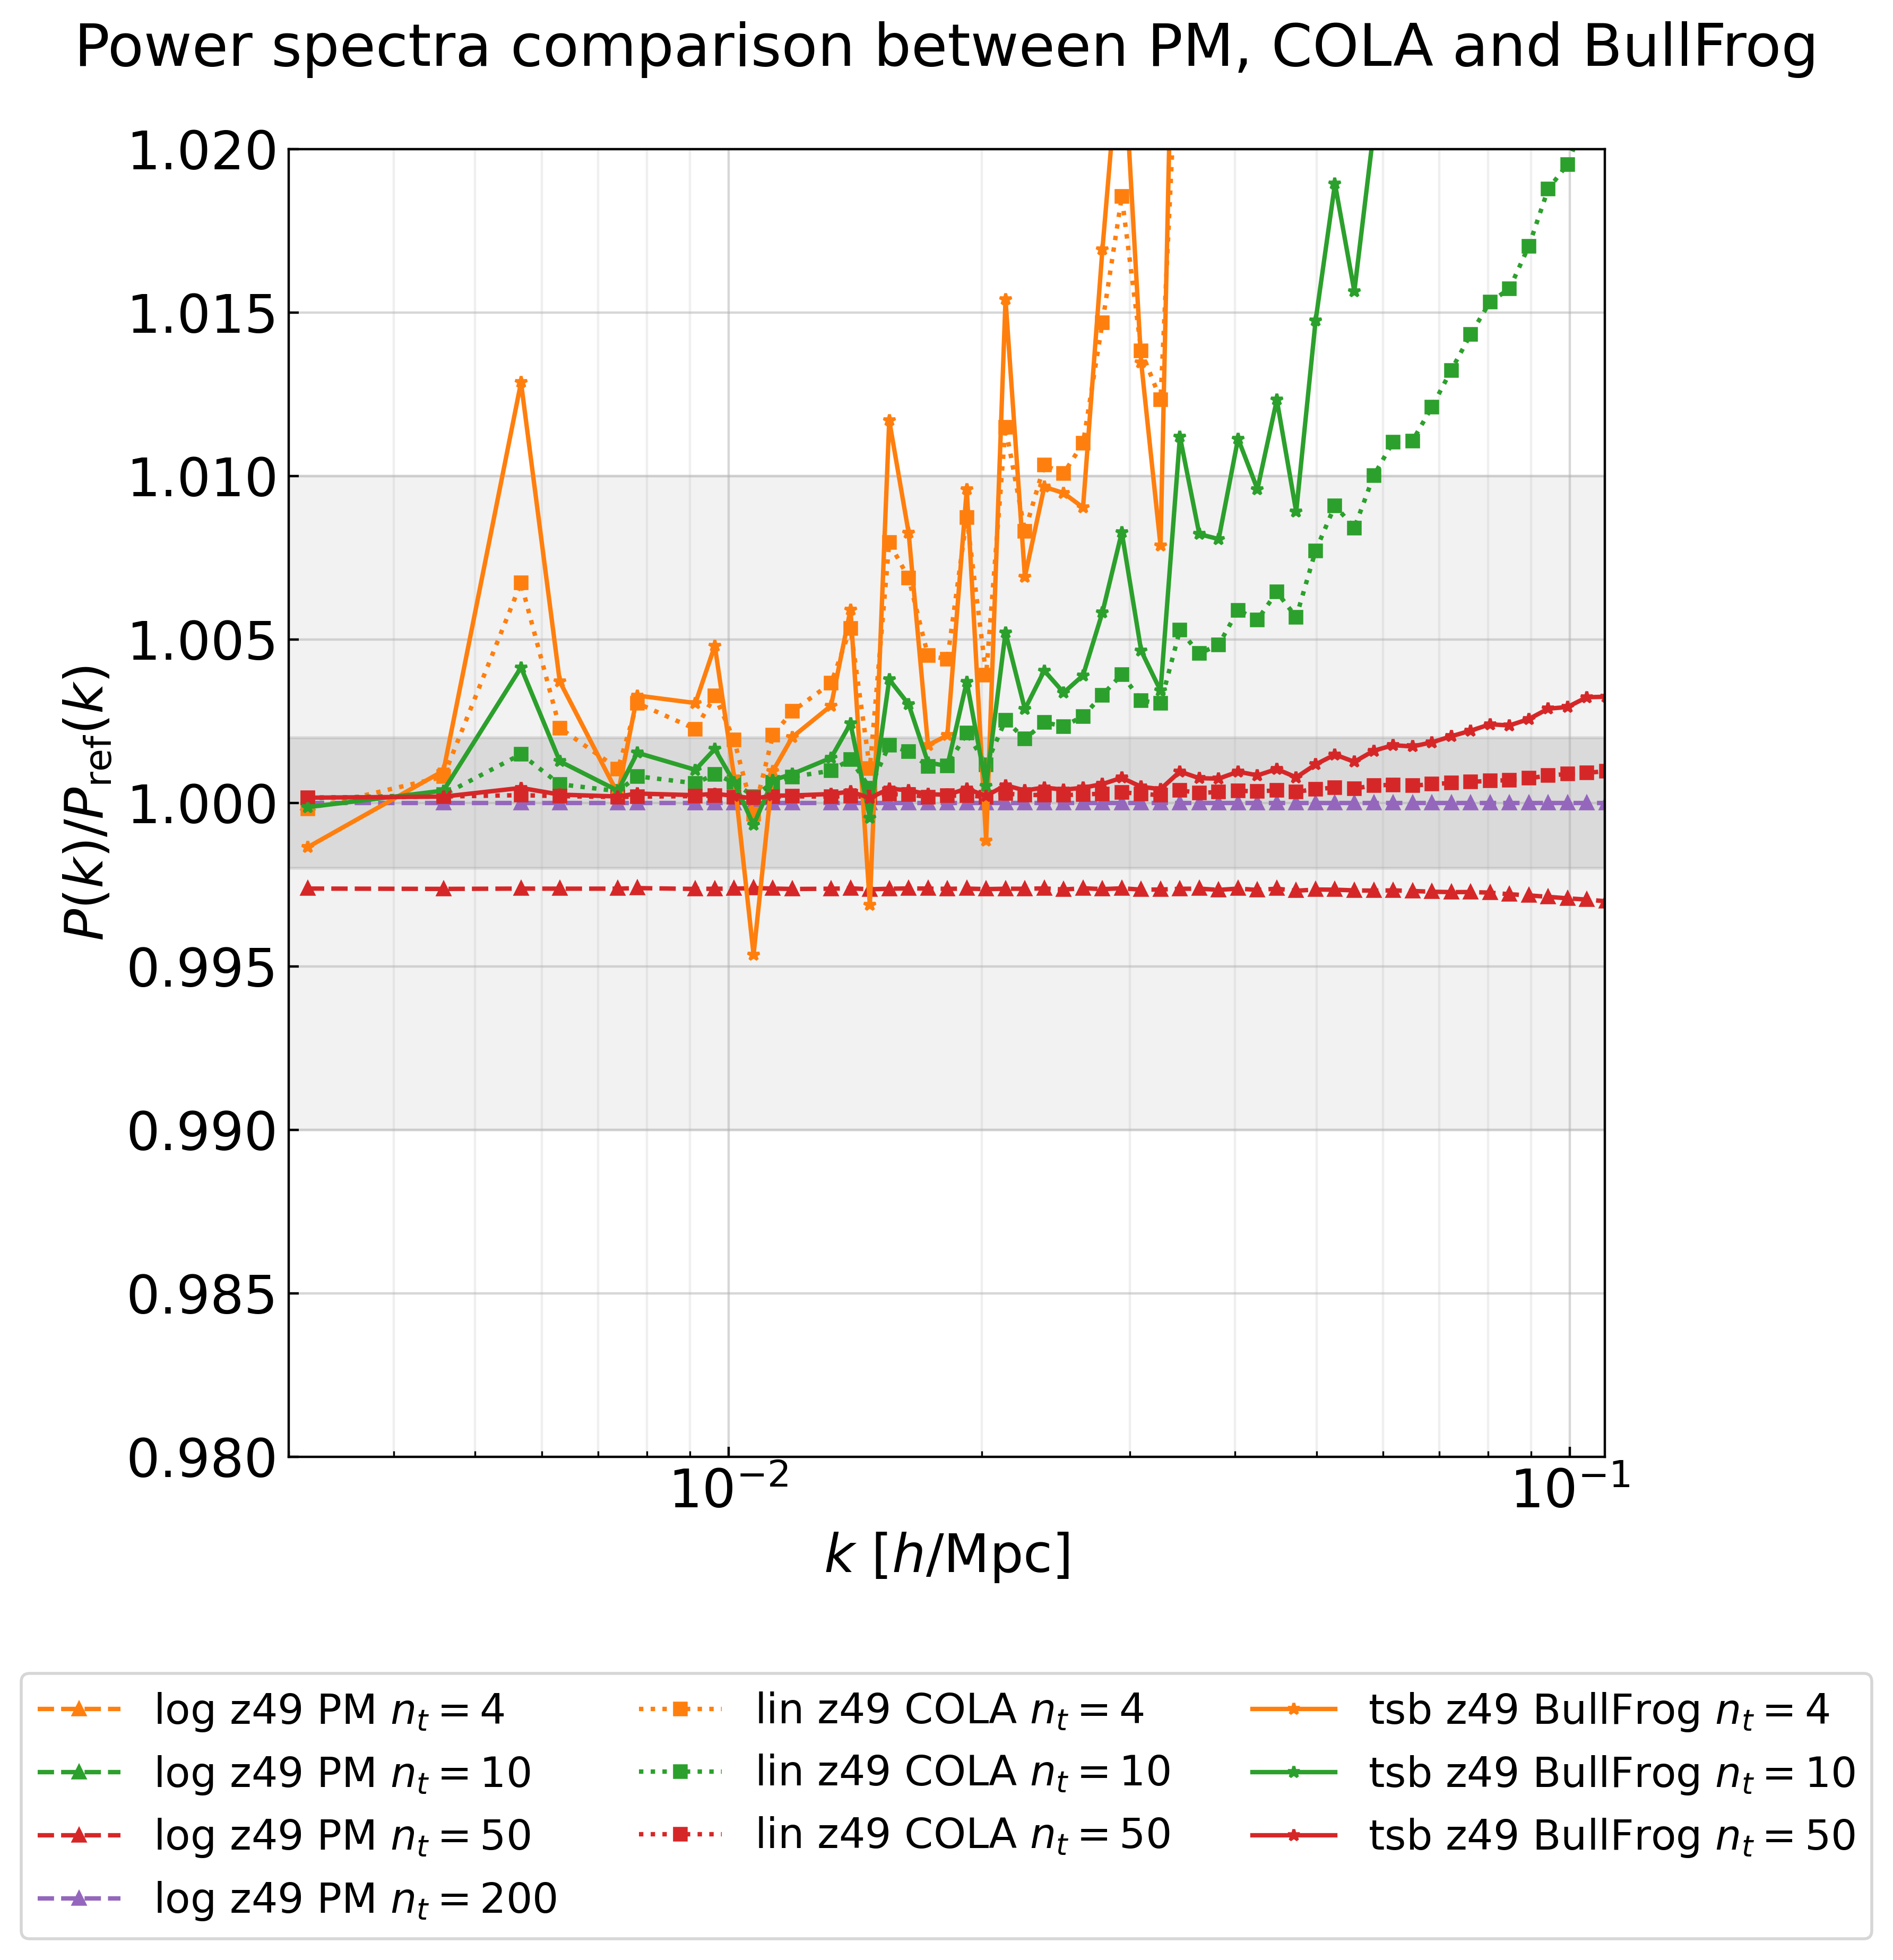

In [31]:
ts_keys = ["log z49", "lin z49", "tsb z49"]
modes = {"tsb z49": ["BullFrog"], "lin z49": ["COLA"], "log z49": ["PM"]}

importlib.reload(plot_utils)

fig, ax = plt.subplots(figsize=(8, 8), dpi=400)

plot_utils.plot_mode_runs_full_comparison(
    ax,
    Pk,
    Pk_ref,
    k,
    ts_keys,
    modes,
    nsteps_all,
    line_styles,
    markers,
    "Power spectra comparison between PM, COLA and BullFrog\n",
    xlims,
    ylims,
    yticks,
    bnd1,
    bnd2,
    False,
    2,
)

fig.show()

## Cross correlations

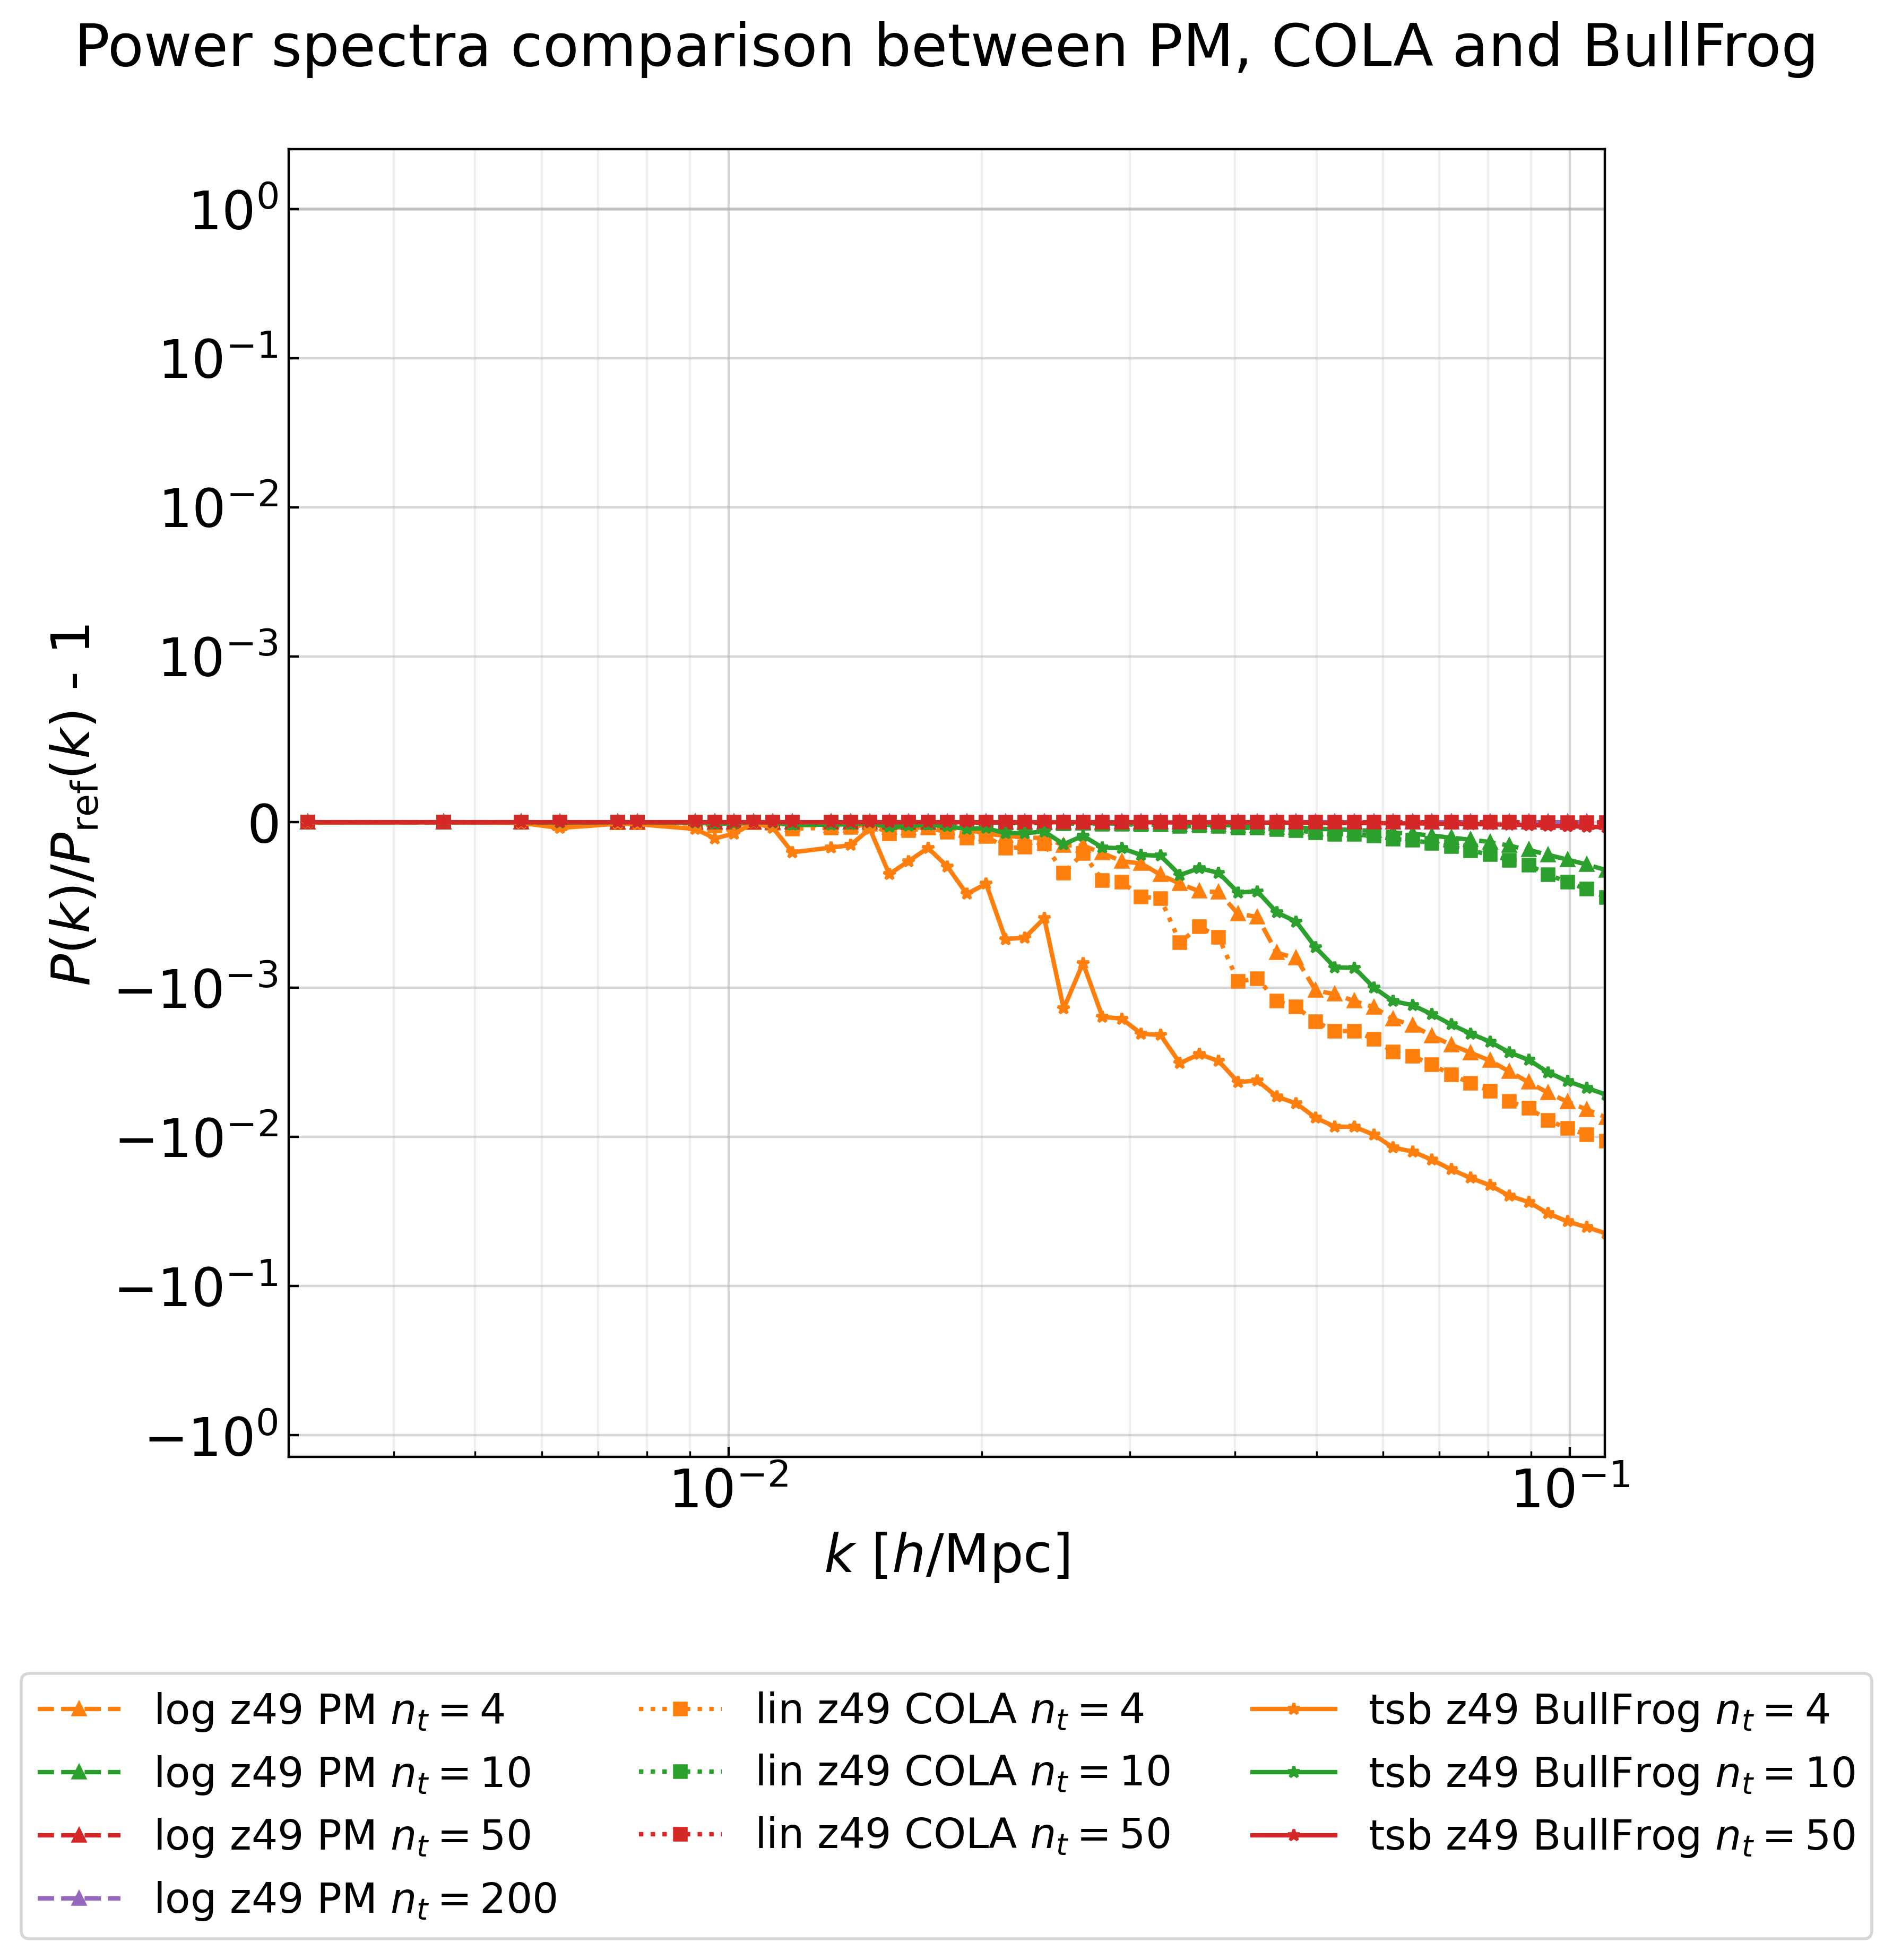

In [36]:
ts_keys = ["log z49", "lin z49", "tsb z49"]
modes = {"tsb z49": ["BullFrog"], "lin z49": ["COLA"], "log z49": ["PM"]}

importlib.reload(plot_utils)

fig, ax = plt.subplots(figsize=(8, 8), dpi=400)

plot_utils.plot_mode_runs_full_comparison(
    ax,
    Rk,
    1.,
    k,
    ts_keys,
    modes,
    nsteps_all,
    line_styles,
    markers,
    "Power spectra comparison between PM, COLA and BullFrog\n",
    xlims,
    ylims_cc,
    yticks_cc,
    bnd1,
    bnd2,
    True,
    2,
)

fig.show()

In [33]:
# ## computes KL divergence
# def KL_divergence(DELTA_ref, DELTA):
#     # convert deltas into densities
#     P = np.clip((1 + np.array(DELTA_ref.data)), 1e-3, 1e12)
#     Q = np.clip((1 + np.array(DELTA.data)), 1e-3, 1e12)
#     assert (
#         P.shape == Q.shape
#     ), f"Different shapes of density fields: {P.shape} and {Q.shape}"

#     sumP = np.sum(P)
#     sumQ = np.sum(Q)
#     return np.sum(P * np.log(P / Q)) / sumP - np.log(sumP / sumQ)

In [34]:
# DELTA_REF = read_field(simdir + f"nsteps{max(nsteps_pm_list)}_final_density_pm.h5")
# KL_PM_list = []
# for nsteps in nsteps_pm_list:
#     DELTA = read_field(simdir + f"nsteps{nsteps}_final_density_pm.h5")
#     KL_PM_list.append(KL_divergence(DELTA_REF, DELTA))

# KL_PM_list = np.array(KL_PM_list)

# KL_COLA_list = []
# for nsteps in nsteps_cola_list:
#     DELTA = read_field(simdir + f"nsteps{nsteps}_final_density_cola.h5")
#     KL_COLA_list.append(KL_divergence(DELTA_REF, DELTA))

# KL_COLA_list = np.array(KL_COLA_list)

# KL_BULLFROG_list = []
# for nsteps in nsteps_bullfrog_list:
#     DELTA = read_field(simdir + f"nsteps{nsteps}_final_density_bullfrog.h5")
#     KL_BULLFROG_list.append(KL_divergence(DELTA_REF, DELTA))


# KL_BULLFROG_list = np.array(KL_BULLFROG_list)

In [35]:
# fig, ax = plt.subplots(figsize=(10, 6))
# ax.plot(
#     nsteps_pm_list[:-1],
#     KL_PM_list[:-1],
#     label="PM",
#     marker="^",
# )
# ax.plot(
#     nsteps_cola_list,
#     KL_COLA_list,
#     label="COLA",
#     marker="o",
# )
# ax.plot(
#     nsteps_bullfrog_list,
#     KL_BULLFROG_list,
#     label="BullFrog",
#     marker="s",
# )
# ax.set_yscale("log")
# ax.set_xscale("log")
# ax.legend()
# ax.set_xlabel("Number of time steps")
# ax.set_ylabel("KL divergence")
# fig.suptitle(
#     "Kullback–Leibler divergence of the density field with respect to a reference density field (PM200)"
# )